<a href="https://colab.research.google.com/github/chandrakiranck/Machinelearning/blob/master/grocery_object_detection_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install numpy==1.17.2

     |████████████████████████████████| 20.4MB 63.4MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


In [0]:
%cd /content/drive/My Drive/grocery-shelves-master/models/research/
!pip install --user pycocotools

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ['PYTHONPATH'] += '/content/drive/My Drive/grocery-shelves-master/models/research/:/content/drive/My Drive/grocery-shelves-master/models/research/slim'
print(os.environ['PYTHONPATH'])

/env/python/content/drive/My Drive/grocery-shelves-master/models/research/:/content/drive/My Drive/grocery-shelves-master/models/research/slim


In [0]:
%cd /content/drive/My Drive/grocery-shelves-master/models/research/

/content/drive/My Drive/grocery-shelves-master/models/research


In [0]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from IPython.display import Image
from PIL import Image
import io
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict
%matplotlib inline

Using TensorFlow backend.


In [0]:
data_path = '/content/drive/My Drive/grocery-shelves-master/data'
# we'll use data from two folders
shelf_images = '/content/drive/My Drive/grocery-shelves-master/data/images/ShelfImages/train/'
product_images = '/content/drive/My Drive/grocery-shelves-master/data/images/ProductImagesFromShelves'

In [0]:
# let's get all shelves photo data from ShelfImages
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

,file,shelf_id,planogram_id
0,C3_P01_N1_S3_1.JPG,C3_P01,N1_S3_1
1,C1_P01_N3_S2_1.JPG,C1_P01,N3_S2_1
2,C1_P06_N1_S4_2.JPG,C1_P06,N1_S4_2
3,C4_P07_N1_S5_1.JPG,C4_P07,N1_S5_1
4,C2_P08_N3_S3_1.JPG,C2_P08,N3_S3_1


In [0]:
# let's get products on shelves photo from ProductImagesFromShelves
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{product_images}/{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1104,1200,196,300,1300,1500
1,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1848,1196,200,304,2048,1500
2,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1508,1644,196,344,1704,1988
3,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1316,688,192,300,1508,988
4,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,2096,656,176,328,2272,984


In [0]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)
# mark all records in data frames with is_train flag
def is_train(shelf_id): return shelf_id in shelves_train
photos_df['is_train'] = photos_df.shelf_id.apply(is_train)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

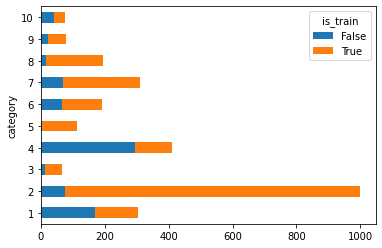

In [0]:
df = products_df[products_df.category != 0].\
         groupby(['category', 'is_train'])['category'].\
         count().unstack('is_train').fillna(0)
df.plot(kind='barh', stacked=True)

In [0]:
# save to pkl
photos_df.to_pickle(f'{data_path}photos.pkl')
products_df.to_pickle(f'{data_path}products.pkl')

In [0]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

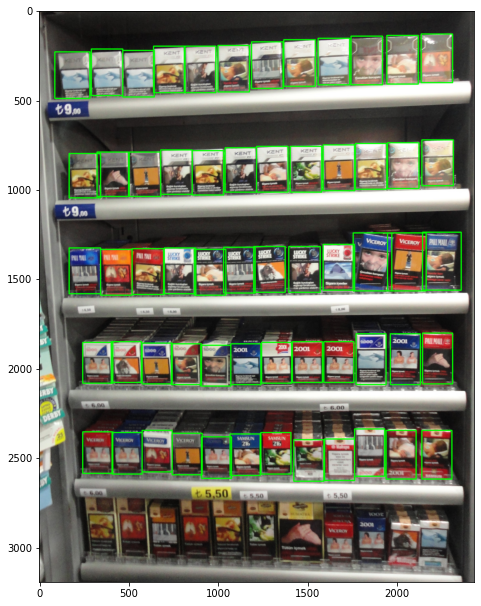

In [0]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C3_P07_N1_S6_1.JPG')

In [0]:
# load data from previous step
photos_df = pd.read_pickle(f'{data_path}photos.pkl')
products_df =  pd.read_pickle(f'{data_path}products.pkl')

In [0]:
"""neural networks work with input of fixed size, so we need to resize our
packs images to the chosen size. The size is some kind of metaparameter and 
you should try different variants. Logically, the bigger size you select,
the better performace you'll have. Unfortunatelly it is not true, because 
of over fitting. The more parameters your neural network have, the easier it
became over fitted"""
num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [0]:
# resize pack to fixed size SHAPE_WIDTH x SHAPE_HEIGHT
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [0]:
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax,is_train
0,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1104,1200,196,300,1300,1500,True
1,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1848,1196,200,304,2048,1500,True
2,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1508,1644,196,344,1704,1988,True
3,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,1316,688,192,300,1508,988,True
4,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0,2096,656,176,328,2272,984,True


In [0]:
# x - image, y - class, f - is_train flag
x, y,f= [], [],[]
for file, is_train in photos_df[['file', 'is_train']].values:
    photo_rects = products_df[products_df.file == file]
    rects_data = photo_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(category - 1)

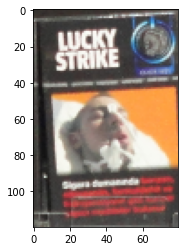

In [0]:
# display one SHAPE_WIDTH x SHAPE_HEIGHT resized pack image, 
# it is hard to recognize category with our eyes, let's see
# how neural network will do the job
plt.imshow(x[36])

In [0]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]
# save validation images
x_validation_images = x_validation

In [0]:
# convert y_train and y_validation to one-hot arrays
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

In [0]:
# normalize x_train, x_validation
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [0]:
# let's see what do we have
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (1515, 120, 80, 3)
y_train shape: (1515, 10)
1515 train samples
604 validation samples


In [0]:
# let's build our ResNet CNN. We don't do any significant changes to keras example
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Learning rate:  0.001


In [0]:
# let's see our model architecture and how may trainable params does it have
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 80, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 80, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 80, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 80, 16)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
# let's run training process, 15 epochs is enough
batch_size = 50
epochs = 15
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])



Epoch 1/15
Learning rate:  0.001
31/31 [==============================] - 8s 268ms/step - loss: 1.0911 - accuracy: 0.7307 - val_loss: 3.2575 - val_accuracy: 0.2318
Epoch 2/15
Learning rate:  0.001
31/31 [==============================] - 3s 100ms/step - loss: 0.4665 - accuracy: 0.9129 - val_loss: 3.2078 - val_accuracy: 0.2417
Epoch 3/15
Learning rate:  0.001
31/31 [==============================] - 4s 120ms/step - loss: 0.2994 - accuracy: 0.9578 - val_loss: 1.8196 - val_accuracy: 0.4586
Epoch 4/15
Learning rate:  0.001
31/31 [==============================] - 4s 120ms/step - loss: 0.2919 - accuracy: 0.9624 - val_loss: 1.3011 - val_accuracy: 0.5877
Epoch 5/15
Learning rate:  0.001
31/31 [==============================] - 4s 119ms/step - loss: 0.2505 - accuracy: 0.9789 - val_loss: 1.1183 - val_accuracy: 0.7003
Epoch 6/15
Learning rate:  0.001
31/31 [==============================] - 4s 120ms/step - loss: 0.2121 - accuracy: 0.9875 - val_loss: 1.3458 - val_accuracy: 0.6921
Epoch 7/15
Lear

In [0]:
# let's estimate our result
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

604/604 [==============================] - 0s 716us/step
Test loss: 0.5215693554341398
Test accuracy: 0.8990066051483154


In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_validation, axis=1)
y_validation_predict = model.predict(x_validation)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

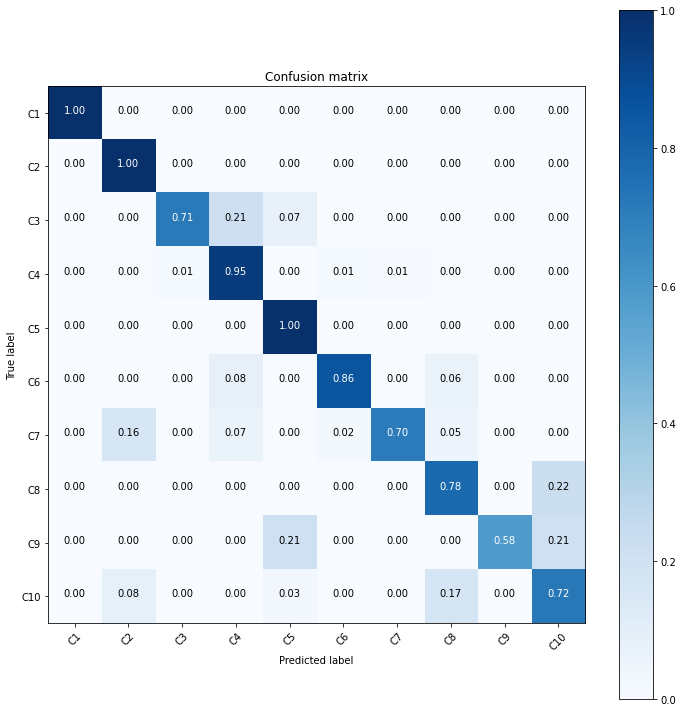

In [0]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=True)

In [0]:
power = np.array([y_validation_predict[i][y_validation_predict_cls[i]] 
                  for i in range(len(y_validation_predict_cls))])


margin = 5
width = num_classes * SHAPE_WIDTH + (num_classes - 1) * margin
height = num_classes * SHAPE_HEIGHT + (num_classes - 1) * margin
confusion_image = np.zeros((height, width, 3), dtype='i')
for i in range(num_classes):
    for j in range(num_classes):
        flags = [(y_validation_cls == i) & (y_validation_predict_cls == j)]
        if not np.any(flags):
            continue
        max_cell_power = np.max(power[flags])
        index = np.argmax(flags & (power == max_cell_power))
        ymin, xmin = (SHAPE_HEIGHT+margin) * i, (SHAPE_WIDTH+margin) * j
        ymax, xmax = ymin + SHAPE_HEIGHT, xmin + SHAPE_WIDTH
        confusion_image[ymin:ymax, xmin:xmax, :] = x_validation_images[index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


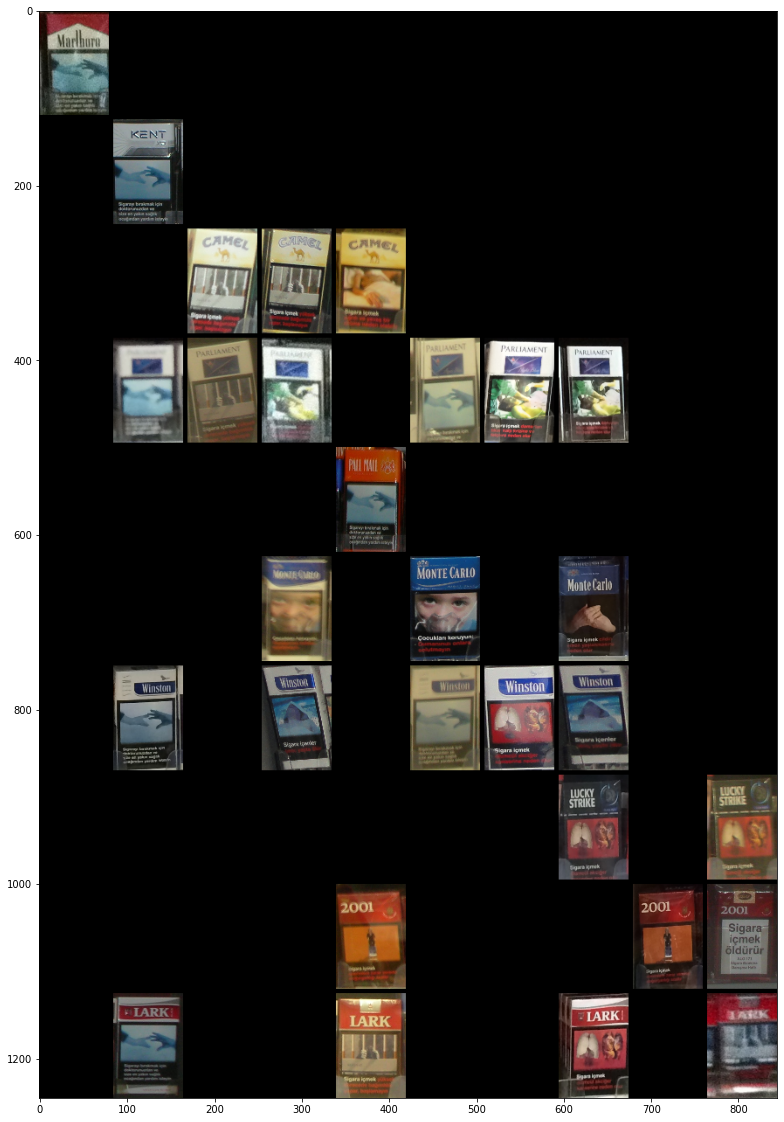

In [0]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.imshow(confusion_image)

In [0]:
# current images path 
img_path = '/content/drive/My Drive/grocery-shelves-master/data/images/ShelfImages/train/'
# cropped parts destination
cropped_path = '/content/drive/My Drive/grocery-shelves-master/data/images/detector/'
# Step 1 results path
data_path = '/content/drive/My Drive/grocery-shelves-master/data/'
# output destination
detector_data_path = '/content/drive/My Drive/grocery-shelves-master/pack_detector/data/'

In [0]:
# read rects and photos dataframes
photos = pd.read_pickle(f'{data_path}photos.pkl')
products = pd.read_pickle(f'{data_path}products.pkl')

In [0]:
N_CROP_TRIALS = 6
CROP_SIZE = 1000

In [0]:
# returns random value in [s, f]
def rand_between(s, f):
    if s == f:
        return s
    return np.random.randint(s, f)

In [0]:
train_products, eval_products = [], []
for img_file, is_train in photos[['file', 'is_train']].values:
    img = cv2.imread(f'{img_path}{img_file}')
    img_h, img_w, img_c = img.shape
    for n in range(N_CROP_TRIALS):
        # randomly crop square
        c_size = rand_between(300, max(img_h, img_w))
        x0 = rand_between(0, max(0, img_w - c_size))
        y0 = rand_between(0, max(0, img_h - c_size))
        x1 = min(img_w, x0 + c_size)
        y1 = min(img_h, y0 + c_size)
        # products totally inside crop rectangle
        crop_products = products[(products.file == img_file) & 
                                 (products.xmin > x0) & (products.xmax < x1) &
                                 (products.ymin > y0) & (products.ymax < y1)]
        # no products inside crop rectangle? cropping trial failed...
        if len(crop_products) == 0:
            continue
        # name the crop
        crop_img_file = f'{img_file[:-4]}{x0}_{y0}_{x1}_{y1}.JPG'
        # crop and reshape to CROP_SIZExCROP_SIZE or smaller 
        # keeping aspect ratio
        crop = img[y0:y1, x0:x1]
        h, w, c = crop.shape
        ratio = min(CROP_SIZE/h, CROP_SIZE/w)
        crop = cv2.resize(crop, (0,0), fx=ratio, fy=ratio)
        crop = crop[0:CROP_SIZE, 0:CROP_SIZE]
        h, w, c = crop.shape
        # add crop inner products to train_products or eval_products list
        for xmin, ymin, xmax, ymax in \
                crop_products[['xmin', 'ymin', 'xmax', 'ymax']].values:
            xmin -= x0
            xmax -= x0
            ymin -= y0
            ymax -= y0

            xmin, xmax, ymin, ymax = [int(np.round(e * ratio)) 
                                      for e in [xmin, xmax, ymin, ymax]]
            product = {'filename': crop_img_file, 'class':'pack', 
                       'width':w, 'height':h,
                       'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}
            if is_train:
                train_products.append(product)
            else:
                eval_products.append(product)
        # save crop top eval or train folder
        subpath = ['eval/', 'train/'][is_train]
        cv2.imwrite(f'{cropped_path}{subpath}{crop_img_file}', crop)

In [0]:
train_df = pd.DataFrame(train_products).set_index('filename')
eval_df = pd.DataFrame(eval_products).set_index('filename')

In [0]:
# at this point we have two folders with images and
# two dataframes with information about packs
train_df.head()

,class,width,height,xmin,ymin,xmax,ymax
filename,,,,,,,
C1_P01_N1_S2_1102_387_1330_1615.JPG,pack,1000,1000,754,441,959,747
C1_P01_N1_S2_1102_387_1330_1615.JPG,pack,1000,1000,155,395,360,701
C1_P01_N1_S2_1102_387_1330_1615.JPG,pack,1000,1000,347,418,552,724
C1_P01_N1_S2_1102_387_1330_1615.JPG,pack,1000,1000,552,424,757,730
C1_P01_N1_S2_1142_806_902_1566.JPG,pack,1000,1000,197,87,529,582


***Preparing Tensorflow Records***


So far we have 2 folders with cropped square images (one for training and one for evaluation). We also have 2 dataframes with information about packs places on each image. Now we need to convert everything to train.record and eval.record files that could be consumed by Tensorflow Object Detection trainer.

In [0]:
def class_text_to_int(row_label):
    if row_label == 'pack':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) 
            for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [0]:
def convert_to_tf_records(images_path, examples, dst_file):
    writer = tf.python_io.TFRecordWriter(dst_file)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, images_path)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [0]:
convert_to_tf_records(f'{cropped_path}train/', train_df, f'{detector_data_path}train.record')
convert_to_tf_records(f'{cropped_path}eval/', eval_df, f'{detector_data_path}eval.record')

In [0]:
%cd /content/drive/My Drive/grocery-shelves-master/models/research/object_detection/
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

/content/drive/My Drive/grocery-shelves-master/models/research/object_detection
--2020-05-14 07:22:22--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.79.128, 2a00:1450:4013:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.79.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76534733 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  72.99M  44.5MB/s    in 1.6s    

2020-05-14 07:22:25 (44.5 MB/s) - ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’ saved [76534733/76534733]



In [0]:
!tar -xvzf ssd_mobilenet_v1_coco_2017_11_17.tar.gz

ssd_mobilenet_v1_coco_2017_11_17/
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2017_11_17/saved_model/
ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables/
ssd_mobilenet_v1_coco_2017_11_17/checkpoint


In [0]:
!ls


anchor_generators		     matchers
box_coders			     meta_architectures
builders			     metrics
CONTRIBUTING.md			     model_hparams.py
core				     model_lib.py
data				     model_lib_test.py
data_decoders			     model_lib_v2.py
dataset_tools			     model_lib_v2_test.py
dockerfiles			     model_main.py
eval_util.py			     models
eval_util_test.py		     model_tpu_main.py
exporter.py			     object_detection_tutorial.ipynb
exporter_test.py		     pack_detector
export_inference_graph.py	     predictors
export_tflite_ssd_graph_lib.py	     protos
export_tflite_ssd_graph_lib_test.py  README.md
export_tflite_ssd_graph.py	     samples
g3doc				     ssd_mobilenet_v1_coco_2017_11_17
inference			     ssd_mobilenet_v1_coco_2017_11_17.tar.gz
__init__.py			     test_data
inputs.py			     test_images
inputs_test.py			     tpu_exporters
legacy				     utils


In [0]:
!python3 model_main.py --logtostderr --model_dir=pack_detector/models/ssd_mobilenet_v1/train/ --pipeline_config_path=pack_detector/models/ssd_mobilenet_v1/ssd_mobilenet_v1_pack.config



W0514 08:39:18.245952 139647768160128 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/utils/config_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0514 08:39:18.250315 139647768160128 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/model_lib.py:685: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0514 08:39:18.250463 139647768160128 model_lib.py:686] Forced number of epochs for all eval validations to be 1.

W0514 08:39:18.250584 139647768160128 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/utils/config_util.py:523: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Maybe overwriting train_steps: None
I0514 08:39:18.250666 139647768160128 confi

In [0]:
%cd /content/drive/My Drive/grocery-shelves-master/models/research/object_detection/

/content/drive/My Drive/grocery-shelves-master/models/research/object_detection/pack_detector


In [0]:
!python3 export_inference_graph.py --input_type image_tensor --pipeline_config_path pack_detector/models/ssd_mobilenet_v1/ssd_mobilenet_v1_pack.config --trained_checkpoint_prefix pack_detector/models/ssd_mobilenet_v1/train/model.ckpt-12788 --output_directory pack_detector/models/ssd_mobilenet_v1/graph_model



W0514 10:30:56.662947 139848044414848 module_wrapper.py:139] From export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0514 10:30:56.670508 139848044414848 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:419: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0514 10:30:56.671003 139848044414848 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:138: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0514 10:30:56.701882 139848044414848 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/core/preprocessor.py:3030: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0514 10:30:56.727200 139848044414848 module_w

I haven Frozen my file at checkpoint **12788**(Transfer Learning)